Notebook color scheme


/home/darth/miniconda3/envs/mlenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


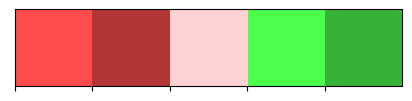

In [1]:
from typing import Any, List, Tuple, Dict, Optional, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import optuna
import os
import sys
import random
import warnings


from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, f1_score, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from tqdm import tqdm_notebook

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from IPython.display import display_markdown, display_latex
from matplotlib.colors import ListedColormap

from datetime import datetime
from copy import deepcopy
from collections import defaultdict
from colorama import Fore, Style
from functools import partial

warnings.filterwarnings('ignore')

class clr:
    S = Style.BRIGHT + Fore.RED
    E = Style.RESET_ALL
    
MY_COLORS = ["#ff4d4d", "#b33636", "#ffd3d3", "#4dff4d", "#36b336"]
MY_CMAP = ListedColormap(MY_COLORS)
print(clr.S+"Notebook color scheme"+clr.E)
sns.palplot(sns.color_palette(MY_COLORS))
plt.show()

In [2]:
df_org = pd.read_csv("./data/health_with_temp.csv")
df_org.head()

,createdAt,eventType,DeviceID,MessageID,path,hops,duckType,corrupted_device,corrupted_message,charging,counter,full,volts,board_temp,room_temperature,room_pressure,packet_loss,is_packet_loss
0,2022-03-11 0:46:45,health,IRDUCK01,M5N7,NaN,1,2,0,0,1,66,0,-3.0,-3.0,33.4,101357.0,-49.0,1
1,2022-03-11 2:24:45,health,IRDUCK01,A7GE,NaN,1,2,0,0,1,115,0,-3.0,-3.0,33.4,101357.0,-20.0,1
2,2022-03-11 3:04:46,health,IRDUCK01,W5SI,NaN,1,2,0,0,1,135,0,-3.0,-3.0,33.4,101357.0,-1.0,0
3,2022-03-11 3:06:45,health,IRDUCK01,G9BR,NaN,1,2,0,0,1,136,0,-3.0,-3.0,33.4,101357.0,-2.0,1
4,2022-03-11 3:10:45,health,IRDUCK01,BMHN,NaN,1,2,0,0,1,138,0,-3.0,-3.0,33.4,101357.0,-26.0,1


In [3]:
df = df_org[['eventType', 'DeviceID', 'hops', 
         'duckType', 'charging', 'counter', 'full', 
         'volts', 'board_temp', 'room_temperature', 'room_pressure', 
         'is_packet_loss']]

df.head()

,eventType,DeviceID,hops,duckType,charging,counter,full,volts,board_temp,room_temperature,room_pressure,is_packet_loss
0,health,IRDUCK01,1,2,1,66,0,-3.0,-3.0,33.4,101357.0,1
1,health,IRDUCK01,1,2,1,115,0,-3.0,-3.0,33.4,101357.0,1
2,health,IRDUCK01,1,2,1,135,0,-3.0,-3.0,33.4,101357.0,0
3,health,IRDUCK01,1,2,1,136,0,-3.0,-3.0,33.4,101357.0,1
4,health,IRDUCK01,1,2,1,138,0,-3.0,-3.0,33.4,101357.0,1


# Exploratory Data Analysis

In [4]:
print(clr.S+"==== Basic Data Information ====="+clr.E)
display_markdown(f"Number of records in the data : ${df.shape[0]}$", raw=True)
display_markdown(f"Number of attributes in the data: ${df.shape[1] - 1}$", raw=True)
print("\n\n")

print(clr.S+"===== Number of unique instances ======"+clr.E)

for col in df.columns:
    if col != "is_packet_loss":
        display_markdown(f"Number of unique values is `{col}`: ${df[col].nunique()}$", raw=True)
print("\n\n")

==== Basic Data Information =====


Number of records in the data : $46393$

Number of attributes in the data: $11$




===== Number of unique instances ======


Number of unique values is `eventType`: $1$

Number of unique values is `DeviceID`: $1$

Number of unique values is `hops`: $2$

Number of unique values is `duckType`: $2$

Number of unique values is `charging`: $2$

Number of unique values is `counter`: $45469$

Number of unique values is `full`: $1$

Number of unique values is `volts`: $28$

Number of unique values is `board_temp`: $227$

Number of unique values is `room_temperature`: $42$

Number of unique values is `room_pressure`: $42$

## - Distribution of `hops`

As per the diagram below, it suggests that in most of the cases there were very data relay. Hence with one shot the data was uploaded into cloud.

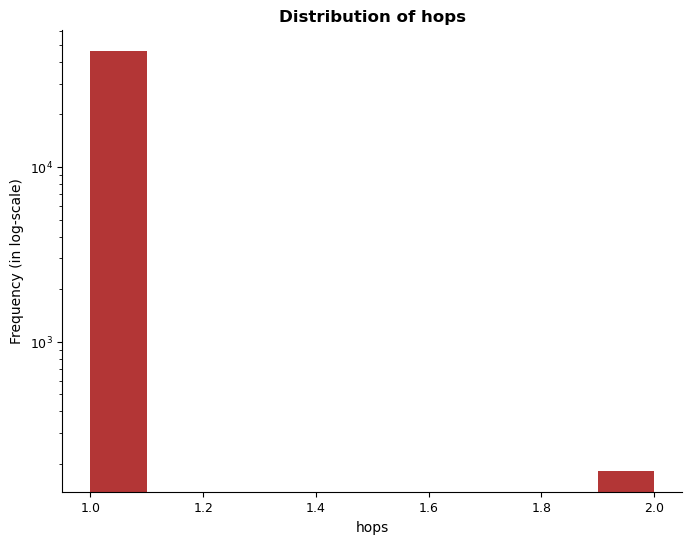

In [5]:
ax = df["hops"].plot(kind="hist", figsize=(8, 6), 
                     fontsize=9, color=MY_COLORS[1])
ax.set_title("Distribution of hops", fontsize=12, weight="bold")
ax.set_yscale('log')
ax.set_ylabel("Frequency (in log-scale)")
ax.set_xlabel("hops")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

## - Distribution of `duckType`

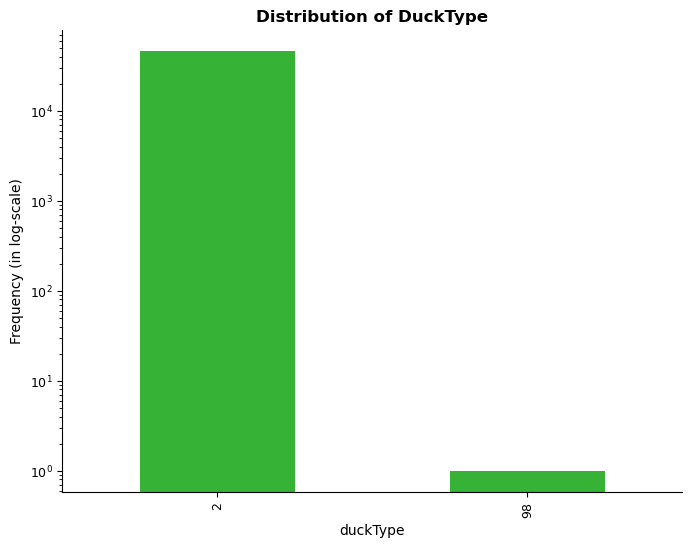

In [6]:
ax = df.groupby("duckType").size().plot(kind="bar", figsize=(8, 6), 
                     fontsize=9, color=MY_COLORS[-1])
ax.set_title("Distribution of DuckType", fontsize=12, weight="bold")
ax.set_yscale('log')
ax.set_ylabel("Frequency (in log-scale)")
ax.set_xlabel("duckType")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

## - Distribution of `charging`

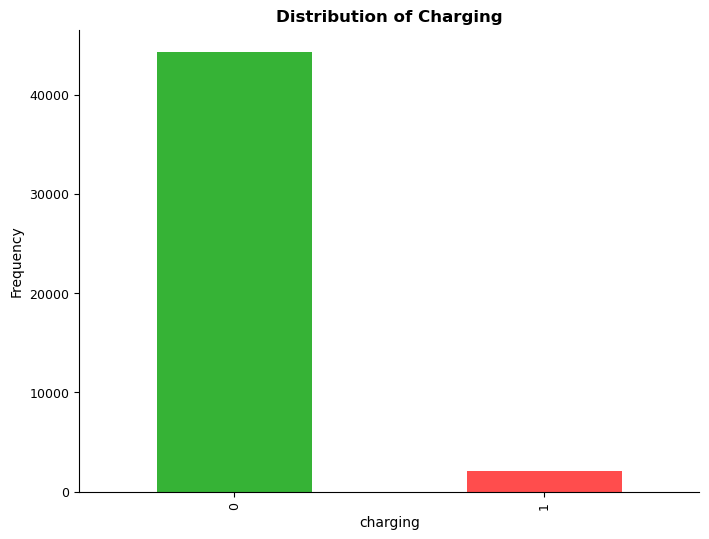

In [7]:
ax = df.groupby("charging").size().plot(kind="bar", figsize=(8, 6), 
                     fontsize=9, color=[MY_COLORS[-1], MY_COLORS[0]])
ax.set_title("Distribution of Charging", fontsize=12, weight="bold")
ax.set_ylabel("Frequency")
ax.set_xlabel("charging")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

## - Distribution of `counter`

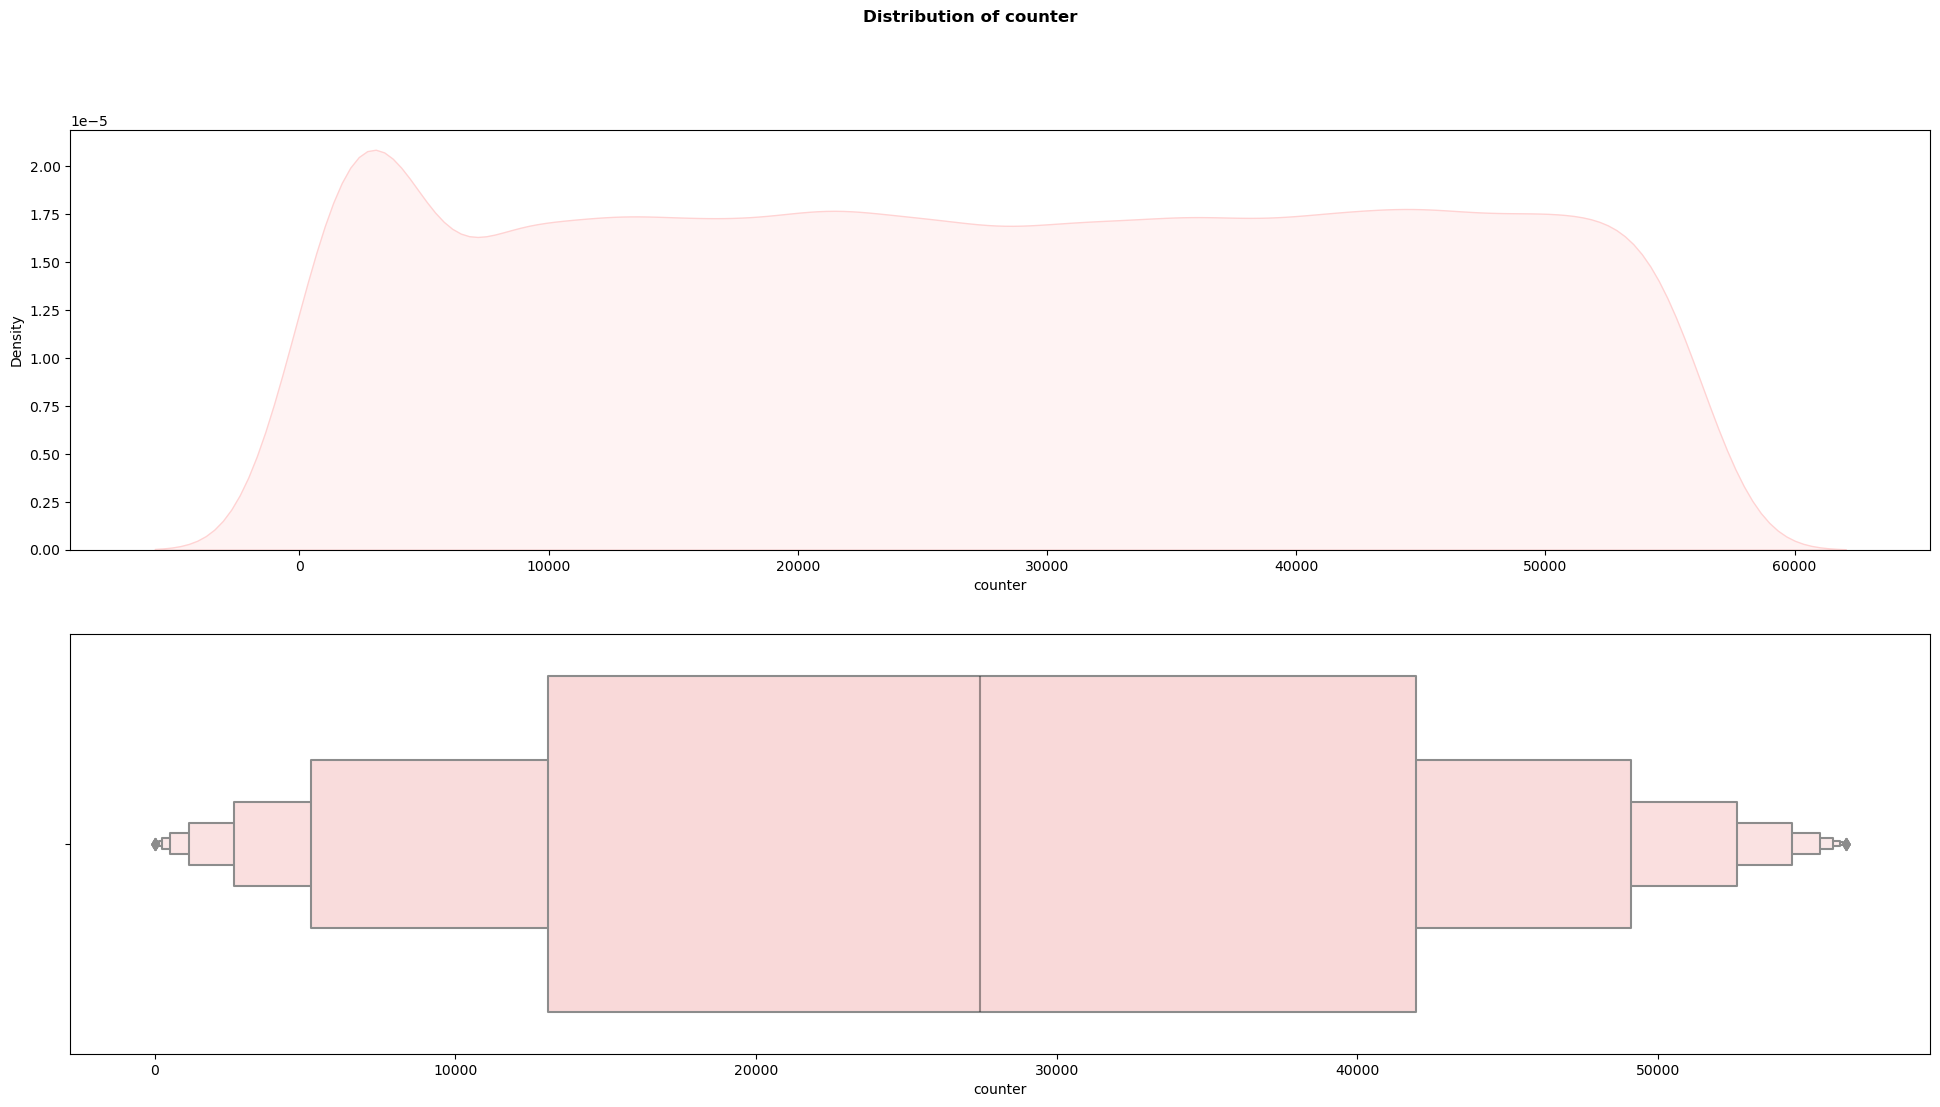

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(24, 12))
axs = axs.flatten()

fig.suptitle("Distribution of counter", fontsize=12, weight="bold")
sns.kdeplot(data=df, x="counter", color=MY_COLORS[-3], fill=True, ax=axs[0])
sns.boxenplot(data=df, x="counter", color=MY_COLORS[-3], ax=axs[1])
plt.show()

## - Distribution of `volts`

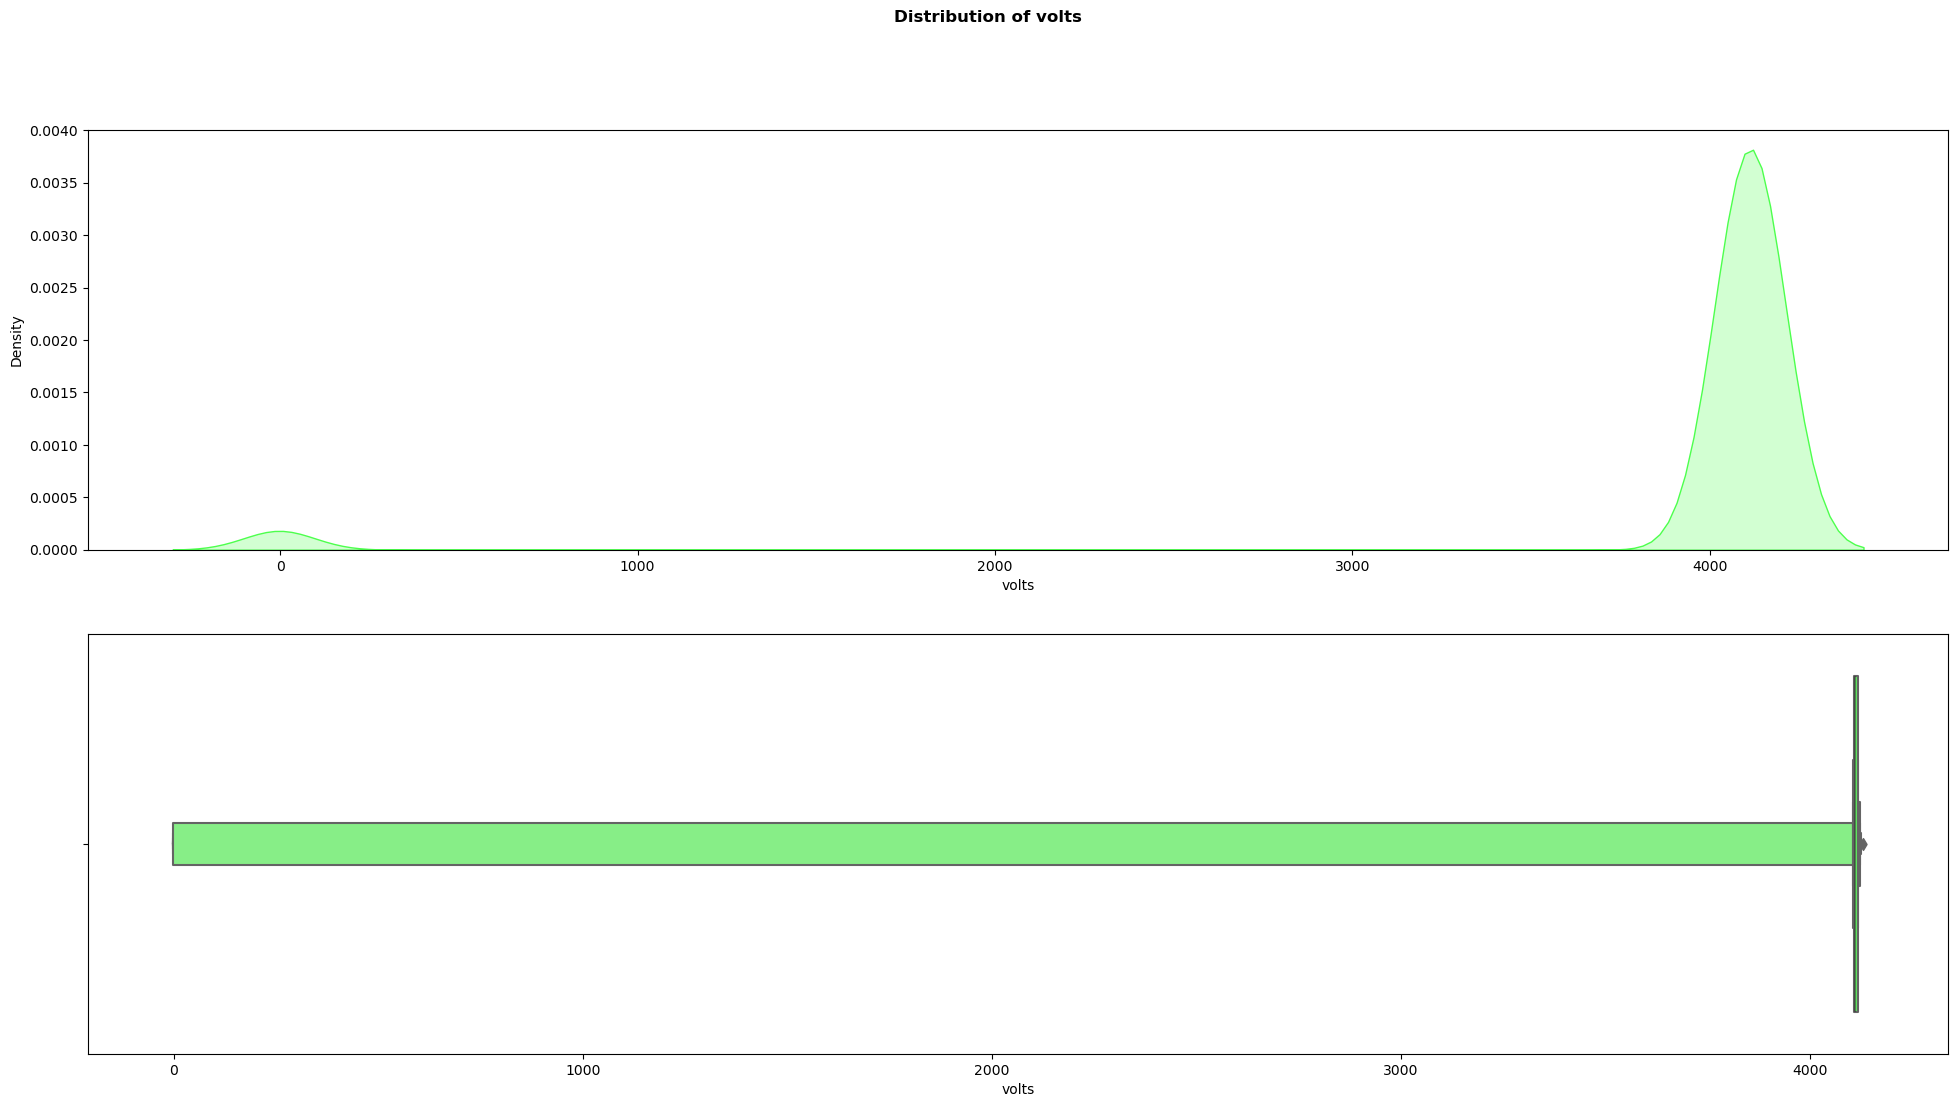

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(24, 12))
axs = axs.flatten()

fig.suptitle("Distribution of volts", fontsize=12, weight="bold")
sns.kdeplot(data=df, x="volts", color=MY_COLORS[-2], fill=True, ax=axs[0])
sns.boxenplot(data=df, x="volts", color=MY_COLORS[-2], ax=axs[1])
plt.show()


## -Distribution of `board_temp`

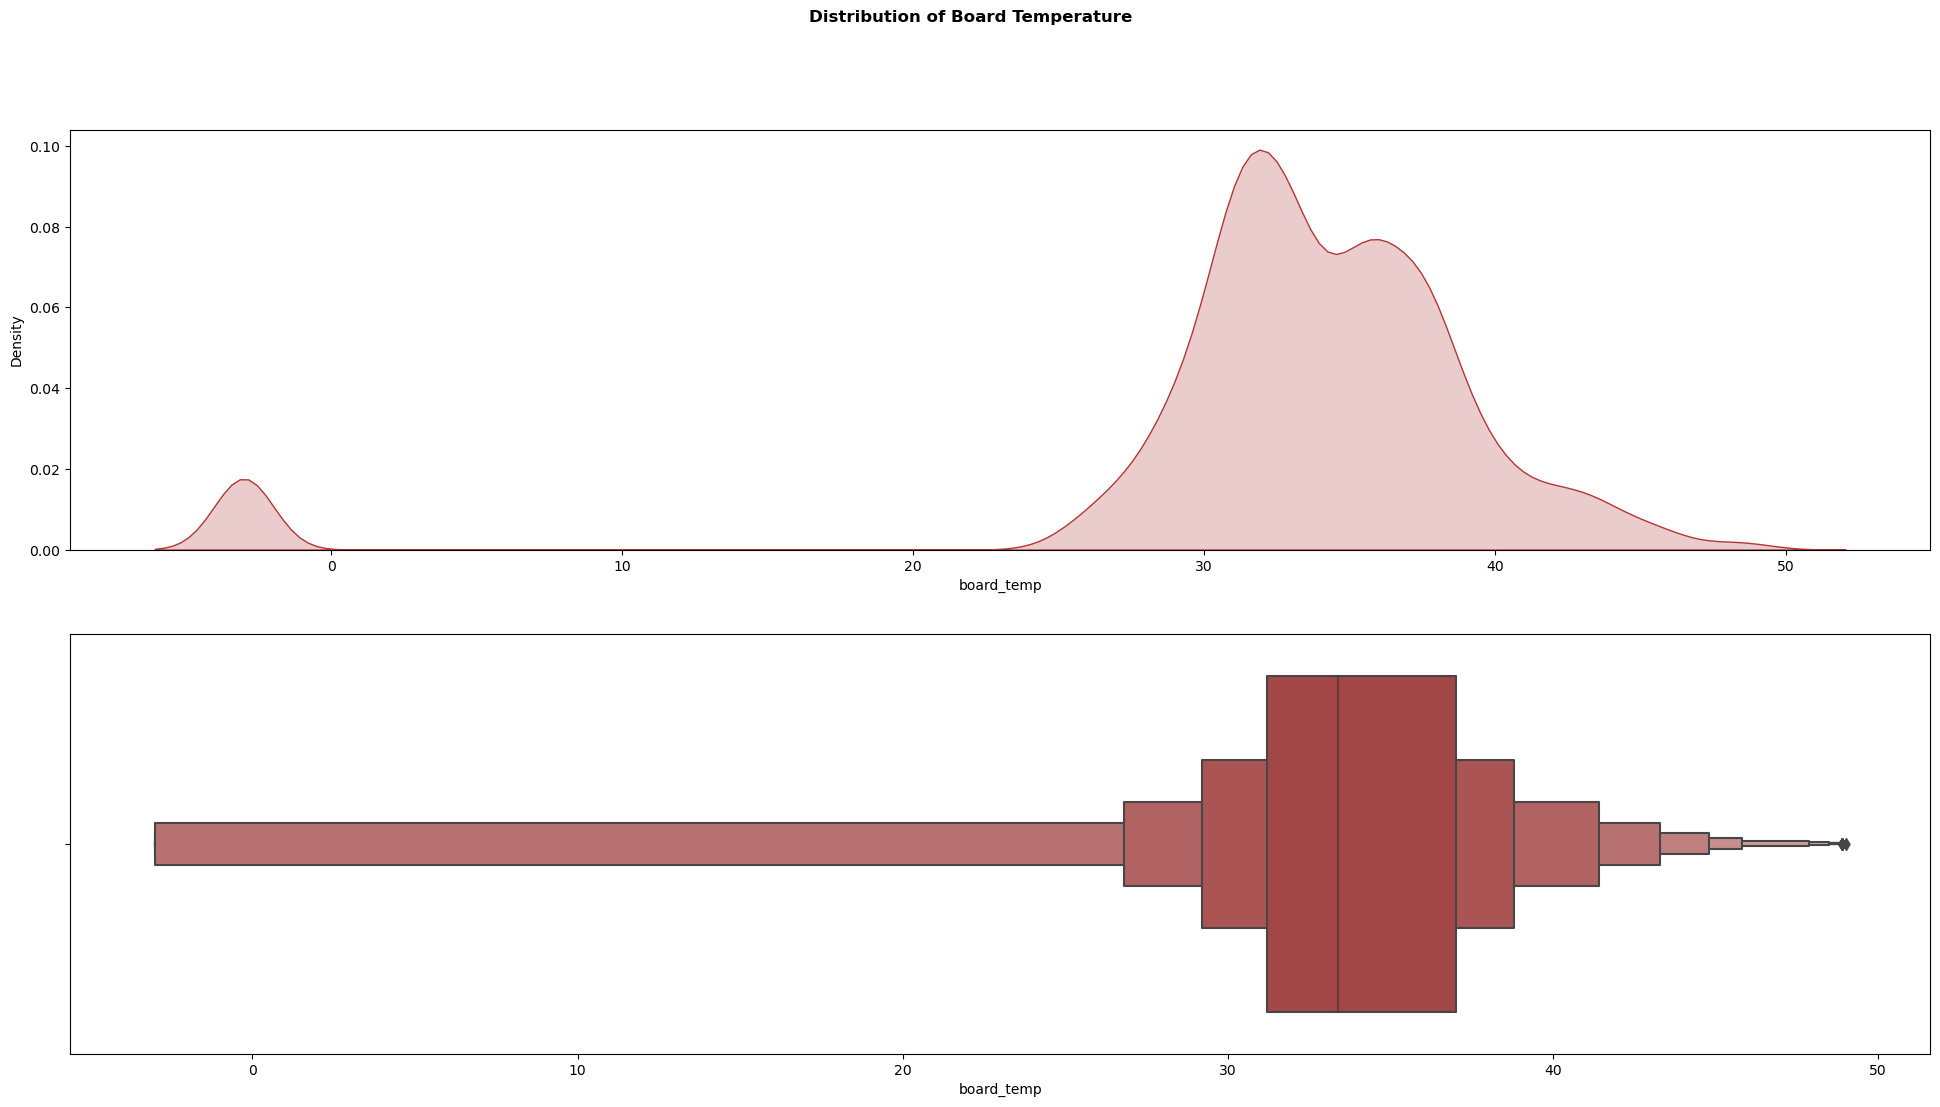

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(24, 12))
axs = axs.flatten()

fig.suptitle("Distribution of Board Temperature", fontsize=12, weight="bold")
sns.kdeplot(data=df, x="board_temp", color=MY_COLORS[1], fill=True, ax=axs[0])
sns.boxenplot(data=df, x="board_temp", color=MY_COLORS[1], ax=axs[1])
plt.show()

## -Distribution of `room_temperature`

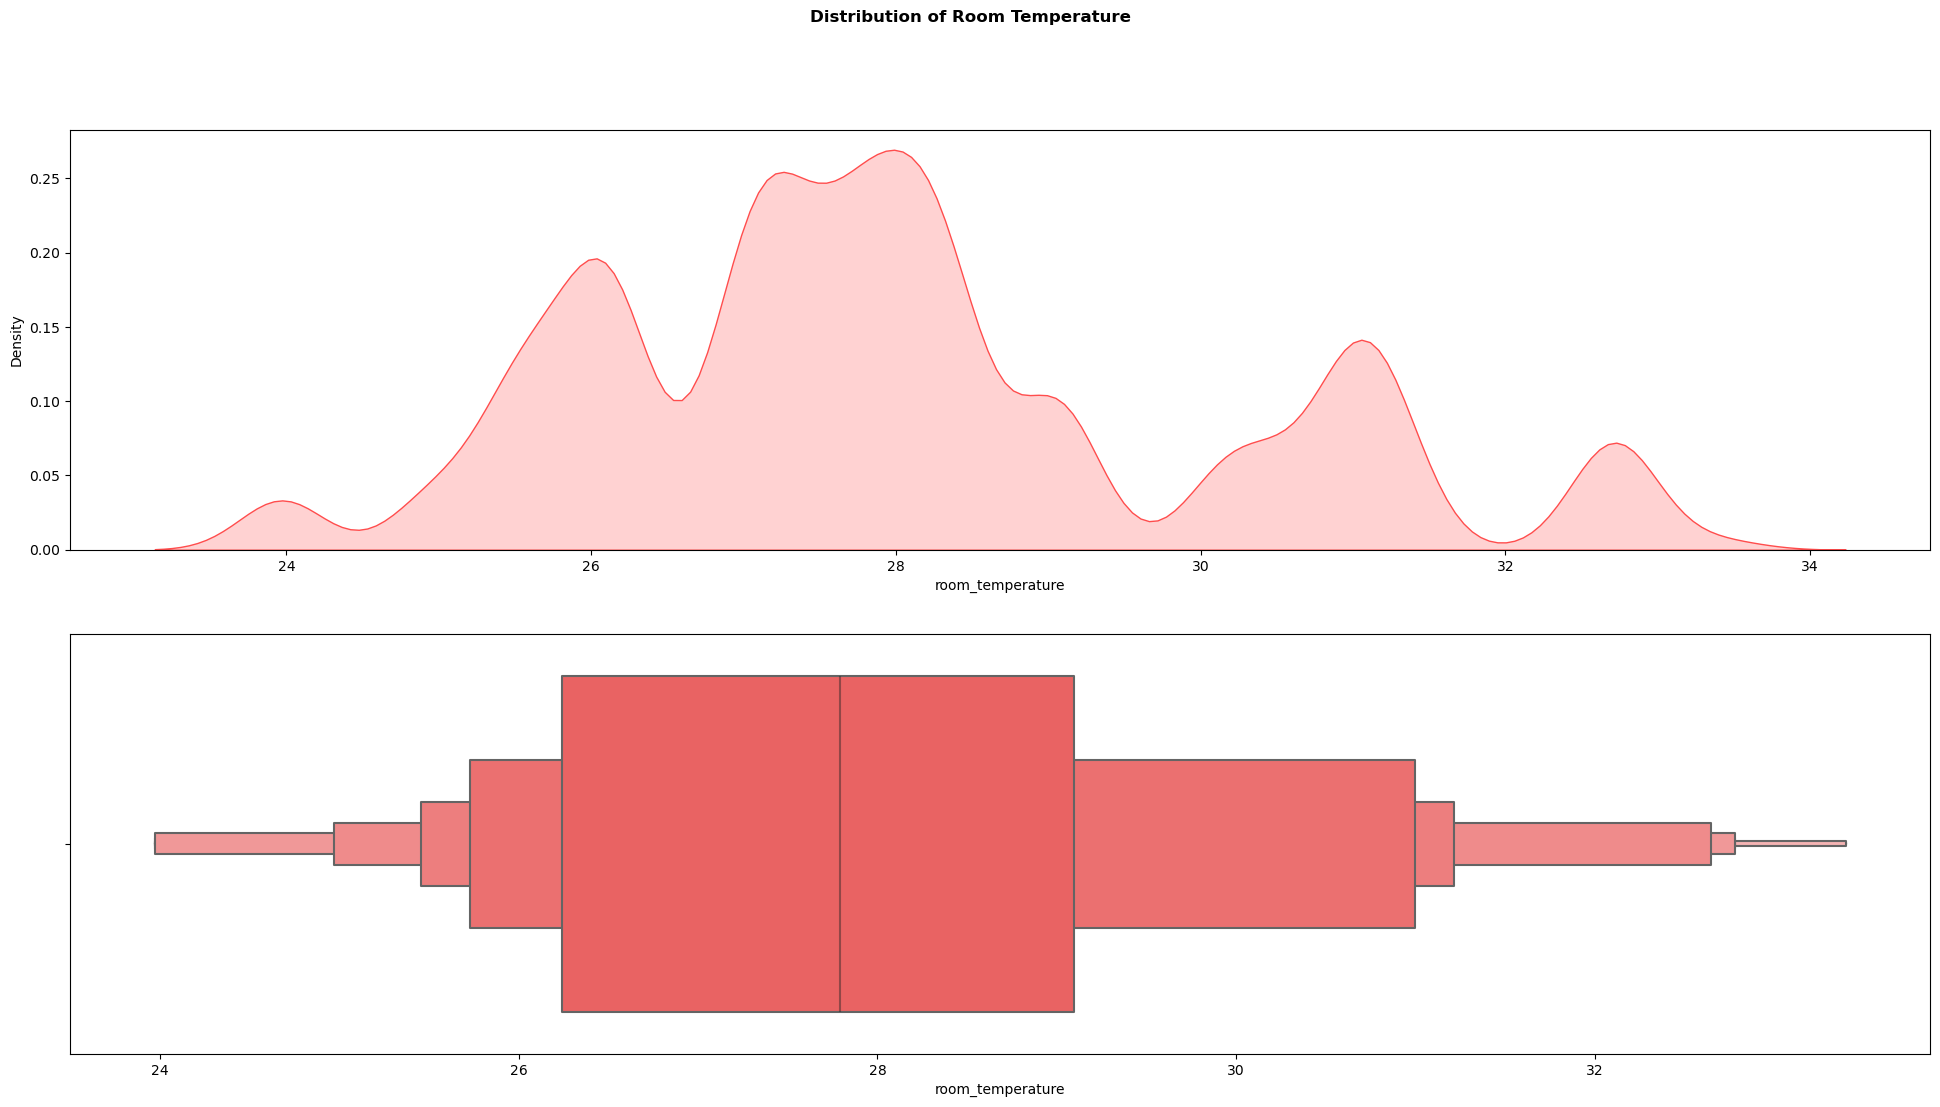

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(24, 12))
axs = axs.flatten()

fig.suptitle("Distribution of Room Temperature", fontsize=12, weight="bold")
sns.kdeplot(data=df, x="room_temperature", color=MY_COLORS[0], fill=True, ax=axs[0])
sns.boxenplot(data=df, x="room_temperature", color=MY_COLORS[0], ax=axs[1])
plt.show()


## -Distribution of `room_pressure`

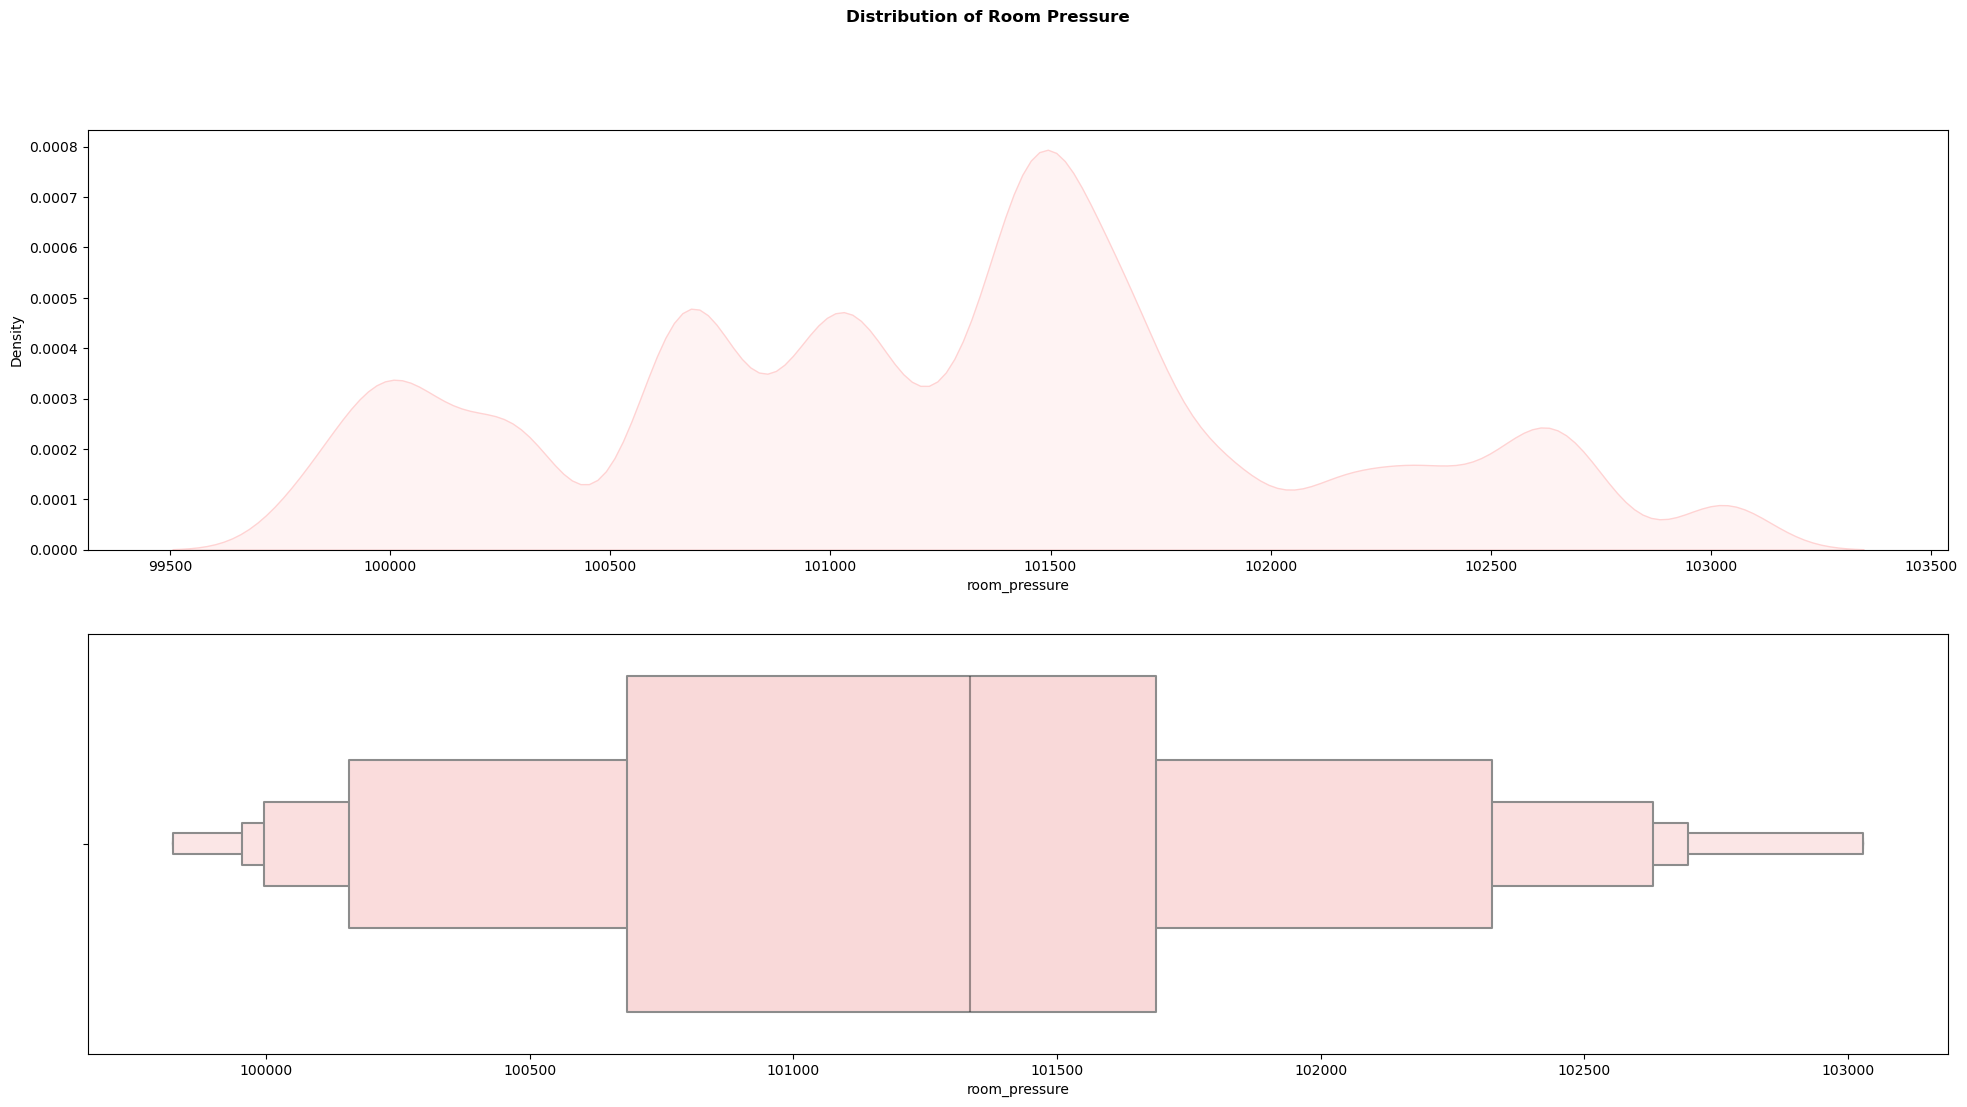

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(24, 12))
axs = axs.flatten()

fig.suptitle("Distribution of Room Pressure", fontsize=12, weight="bold")
sns.kdeplot(data=df, x="room_pressure", color=MY_COLORS[2], fill=True, ax=axs[0])
sns.boxenplot(data=df, x="room_pressure", color=MY_COLORS[2], ax=axs[1])
plt.show()


## -Distribution of `is_packet_loss`

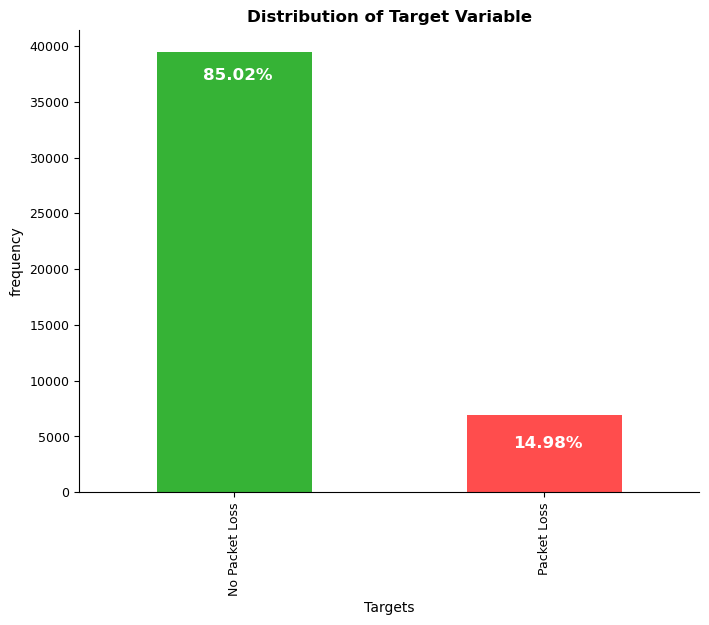

In [77]:
packet_loss_vals = df['is_packet_loss'].value_counts().tolist()
ax = df['is_packet_loss'].value_counts().plot(kind="bar", figsize=(8, 6), 
                                       color = [MY_COLORS[-1], MY_COLORS[0]], fontsize=9)

ax.set_title("Distribution of Target Variable", fontsize=12, weight="bold")
ax.set_xlabel("Targets")
ax.set_ylabel("frequency")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks(ticks=[0, 1], labels=["No Packet Loss", "Packet Loss"])

ax.text(-.1, 37000, f"{packet_loss_vals[0]/df.shape[0] * 100:.2f}%", fontdict={'weight':"bold", 'fontsize':12, "color":"white"})
ax.text(.9, 4000, f"{packet_loss_vals[1]/df.shape[0] * 100:.2f}%", fontdict={'weight':"bold", 'fontsize':12, "color":"white"})
plt.show()

# Notable Observations

* For attributes such as `eventType`,  `DeviceID` and `full`  the number of unique values is $1$, which therefore this suggests that these attribute should be dropped while modelling as it will provide no additional input to the model.

* There is only $1$ instance of `duckType` $=98$, and removing that will lead to the attribute having a single unique value which will not be of great importance. Hence, it's better that it's ignored while modeling.

* From the plots for the `volts` and `board_temp` it is seen that there are quite a few observations where a value of $<0$ is present. This value indicates that the sensor was unable to read the values during that time.

* From the distribution of the target variable it is obvious that we are dealing with imbalanced classes.


# Data Cleaning

In [14]:
df_clean = df.drop(['eventType', 'DeviceID', 'full', 'duckType'], axis=1)
df_clean.head()

,hops,charging,counter,volts,board_temp,room_temperature,room_pressure,is_packet_loss
0,1,1,66,-3.0,-3.0,33.4,101357.0,1
1,1,1,115,-3.0,-3.0,33.4,101357.0,1
2,1,1,135,-3.0,-3.0,33.4,101357.0,0
3,1,1,136,-3.0,-3.0,33.4,101357.0,1
4,1,1,138,-3.0,-3.0,33.4,101357.0,1


# Data Splitting

In [15]:
df_train, df_test = train_test_split(df_clean, test_size=.25, random_state=42, stratify=df['is_packet_loss'])

print(clr.S+"====Training Data Information===="+clr.E)
display_markdown(f"Number of records : ${df_train.shape[0]}$", raw=True)
display_markdown(f"Number of attributes : ${df_train.shape[1] - 1}$", raw=True)
print("\n\n")


print(clr.S+"====Test Data Information===="+clr.E)
display_markdown(f"Number of records : ${df_test.shape[0]}$", raw=True)
display_markdown(f"Number of attributes : ${df_test.shape[1] - 1}$", raw=True)
print("\n\n")


====Training Data Information====


Number of records : $34794$

Number of attributes : $7$




====Test Data Information====


Number of records : $11599$

Number of attributes : $7$

# Class Weight Calculation

In [16]:
n_neg = df_train[df_train['is_packet_loss'] == 0].shape[0]
n_pos = df_train[df_train['is_packet_loss'] == 1].shape[0]

display_markdown(f"Number of `pos` classes : ${n_pos}$", raw=True)
display_markdown(f"Number of `neg` classes : ${n_neg}$", raw=True)

class_wts = {0:1/(n_neg/(n_neg+n_pos)), 1:1/(n_pos/(n_neg+n_pos))}

Number of `pos` classes : $5212$

Number of `neg` classes : $29582$

# Data Modelling

## -Define Scoring Function

In [17]:
def score_fn(y_true:np.ndarray, y_pred:np.ndarray) -> float:
    """
    This function calculates the model score and returns it.
    
    :param y_true: the true value of the data.
    :param y_pred: the predicted value of the data.
    
    :returns: the model score on the data.
    """
    
    score = f1_score(y_true, y_pred)
    return score

## - Define Hyperparameter Optimization

In [30]:
def objective(trial:optuna.Trial, data:pd.DataFrame, model_name:str, 
              n_splits:Optional[int]=3, n_reps:Optional[int]=10, class_weights:Optional[Dict]=None) -> float:
    """
    This function is used as a optimization function for optuna
    
    :param trial: an optuna object to keep track of trials.
    :param data: the data on which to optimize the hyperparameters.
    :param model_name: the name of the model to optimize
    :param n_splits: the number of splits for cross-validation.
    :param n_reps: the number of repetetion for cross-validation.
    :param class_weights: the class weights for the classes.
    
    :returns: the score of the model on the data.
    """
    
    model_names = ["LogReg", "XGB"]
    if model_name not in model_names:
        raise Exception(f"Expected model names to be either {'/'.join(model_name)}; found {model_name}!")
    
    
    if model_name == "LogReg":
        model_params = {
            "C" : trial.suggest_categorical("C", [1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 1., 10, 100, 500, 1000]),
            "class_weight" : trial.suggest_categorical("class_weight", [None, class_weights])            
        }
    else:
        model_params = {
            "n_estimators" : trial.suggest_int("n_estimators", 100, 5000, step=100),
            "eta" : trial.suggest_float("eta", 1e-4, 1., log=True),
            "max_depth" : trial.suggest_int("max_depth", 6, 32, step=2),
            "lambda" : trial.suggest_float("lambda", 1e-2, 10),
            "alpha" : trial.suggest_float("alpha", 1e-2, 10),
            "colsample_bytree" : trial.suggest_float("colsample_bytree", 1e-5, 1),
            "scale_pos_weight" : trial.suggest_categorical("scale_pos_weight", [1, n_neg / n_pos])
        }
    
    
    
    models = {
        "LogReg" : LogisticRegression,
        "XGB" : xgb.XGBClassifier,
    }
    
    
    kfold = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_reps)
    scores = list()
    
    for (train_idx, val_idx) in kfold.split(data.iloc[:, :-1], data.iloc[:, -1]):
        train_data, val_data = data.iloc[train_idx], data.iloc[val_idx]
        
        
        if model_name == "XGB":
            model = models[model_name](objective="binary:logistic",
                                       sampling_method="gradient_based", 
                                       tree_method="gpu_hist", 
                                       grow_policy="lossguide", 
                                       predictor="gpu_predictor", verbosity=3, random_state=42, n_jobs=-1, **model_params)
        else:
            model = models[model_name](n_jobs=-1, **model_params, random_state=42)
            
        pipeline = Pipeline([
            ("missing_imputation", ColumnTransformer([
                ("missing_feats", SimpleImputer(), ["room_temperature", "room_pressure"]),
            ], remainder='passthrough'),),
            ("preprocess", ColumnTransformer(
                transformers = [
                    ("numeric_feats", MinMaxScaler(), [0, 2, 3, 4, 5, 6]) 
                ], remainder="passthrough"
            ),),
            ("model", model)
        ])
            
        pipeline.fit(train_data.iloc[:, :-1], train_data.iloc[:, -1])
        
        val_preds = pipeline.predict(val_data.iloc[:, :-1])
        score = score_fn(val_data.iloc[:, -1], val_preds)
        scores.append(score)
        
    return np.mean(scores)

In [31]:
def early_stop_check(study:optuna.study.Study, trial:optuna.trial.Trial, rounds:int=5) -> None:
    """
    This function acts as a early stopping criteria for optuna.
    
    :param study: the optuna study.
    :param trial: the optuna trial.
    :param rounds: number of steps to follow before early-stopping.
    
    """
    curnt_trl_num = trial.number
    bst_trl_num = study.best_trial.number
    diff = curnt_trl_num - bst_trl_num
    
    if diff >= rounds:
        print(clr.S+"Early Stopping detected !!"+clr.E)
        study.stop()

In [32]:
def run_optuna_trials(data:pd.DataFrame, model_name:str, 
                      n_splits:Optional[int]=3, n_reps:Optional[int]=10,
                      class_weights:Optional[Dict]=None, n_trials:Optional[int]=50, early_stop_rounds:Optional[int]=3) -> Dict:
    """
    Function to run the optuna trials and produce the hyperparameters for the data.
    
    :param data: the training data.
    :param model_name: the name of the model
    :param n_splits: number of Cross-Validation splits
    :param n_reps: number of Cross-Validation Repetetion
    :param class_weights: the class_weights.
    :param n_trials: the number of optuna trials.
    
    :returns: the best hyperparameters.
    """
    
    sampler = optuna.samplers.TPESampler(seed=1234)
    study = optuna.create_study(
        study_name = f"{model_name}_study",
        sampler = sampler,
        direction = "maximize",
        load_if_exists = True,
        storage="sqlite:///study_duckprotocol_repeatedcv.db"
    )
    
    func = lambda trial: objective(trial, data, model_name, n_splits=n_splits, n_reps=n_reps, class_weights=class_weights)
    
    study.optimize(func, n_trials=n_trials, callbacks=[partial(early_stop_check, rounds=early_stop_rounds)])
    
    best_hyp = dict()
    
    for k, v in study.best_trial.params.items():
            best_hyp[k] = v
    
    return best_hyp

## - Logistic Regression (Baseline)

In [33]:
log_reg_best_hyp = run_optuna_trials(df_train, "LogReg", class_weights=class_wts, early_stop_rounds=5)

[I 2023-01-30 03:27:17,312] Using an existing study with name 'LogReg_study' instead of creating a new one.
[I 2023-01-30 03:27:30,452] Trial 6 finished with value: 0.25693983232666906 and parameters: {'C': 10, 'class_weight': {0: 1.1761882225677778, 1: 6.675748273215656}}. Best is trial 6 with value: 0.25693983232666906.
[I 2023-01-30 03:27:46,564] Trial 7 finished with value: 0.2572779142674518 and parameters: {'C': 500, 'class_weight': {0: 1.1761882225677778, 1: 6.675748273215656}}. Best is trial 7 with value: 0.2572779142674518.
[I 2023-01-30 03:28:02,794] Trial 8 finished with value: 0.2566479065341849 and parameters: {'C': 100, 'class_weight': {0: 1.1761882225677778, 1: 6.675748273215656}}. Best is trial 7 with value: 0.2572779142674518.
[I 2023-01-30 03:28:19,035] Trial 9 finished with value: 0.25700133391024194 and parameters: {'C': 0.0001, 'class_weight': {0: 1.1761882225677778, 1: 6.675748273215656}}. Best is trial 7 with value: 0.2572779142674518.
[I 2023-01-30 03:28:34,986]

Early Stopping detected !!


## - XGBoost 

In [34]:
xgb_best_hyp = run_optuna_trials(df_train, "XGB", class_weights=class_wts, early_stop_rounds=5)

[I 2023-01-30 03:29:07,157] A new study created in RDB with name: XGB_study


[03:29:07] ======== Monitor (0): HostSketchContainer ========
[03:29:07] AllReduce: 0.000785s, 1 calls @ 785us

[03:29:07] MakeCuts: 0.000815s, 1 calls @ 815us

[03:29:07] DEBUG: ../src/tree/updater_gpu_hist.cu:736: [GPU Hist]: Configure
[03:29:07] ======== Monitor (0):  ========
[03:29:07] InitCompressedData: 1.2e-05s, 1 calls @ 12us

[03:29:10] ======== Monitor (0): Learner ========
[03:29:10] Configure: 0.390628s, 1 calls @ 390628us

[03:29:10] EvalOneIter: 0.001703s, 1000 calls @ 1703us

[03:29:10] GetGradient: 0.014199s, 1000 calls @ 14199us

[03:29:10] PredictRaw: 0.000904s, 1000 calls @ 904us

[03:29:10] UpdateOneIter: 3.57613s, 1000 calls @ 3576135us

[03:29:10] ======== Monitor (0): GBTree ========
[03:29:10] BoostNewTrees: 3.1656s, 1000 calls @ 3165604us

[03:29:10] CommitModel: 0.000101s, 1000 calls @ 101us

[03:29:10] ======== Device 0 Memory Allocations:  ========
[03:29:10] Peak memory usage: 33MiB
[03:29:10] Number of allocations: 244644
[03:29:10] ======== Monitor (0): 

[I 2023-01-30 03:30:39,448] Trial 0 finished with value: 0.29312595443428574 and parameters: {'n_estimators': 1000, 'eta': 0.03079180048983015, 'max_depth': 18, 'lambda': 7.855732251300554, 'alpha': 7.801958323106847, 'colsample_bytree': 0.2725998793565888, 'scale_pos_weight': 5.675748273215656}. Best is trial 0 with value: 0.29312595443428574.


[03:30:39] ======== Monitor (0): Learner ========
[03:30:39] Configure: 0.00034s, 1 calls @ 340us

[03:30:39] EvalOneIter: 0.0018s, 1000 calls @ 1800us

[03:30:39] GetGradient: 0.015845s, 1000 calls @ 15845us

[03:30:39] PredictRaw: 0.000435s, 1000 calls @ 435us

[03:30:39] UpdateOneIter: 3.43647s, 1000 calls @ 3436470us

[03:30:39] ======== Monitor (0): GBTree ========
[03:30:39] BoostNewTrees: 3.41484s, 1000 calls @ 3414841us

[03:30:39] CommitModel: 9.9e-05s, 1000 calls @ 99us

[03:30:39] ======== Device 0 Memory Allocations:  ========
[03:30:39] Peak memory usage: 43MiB
[03:30:39] Number of allocations: 6816366
[03:30:39] ======== Monitor (0): updater_gpu_hist ========
[03:30:39] InitData: 0.000449s, 1000 calls @ 449us

[03:30:39] InitDataOnce: 0.000371s, 1 calls @ 371us

[03:30:39] Update: 3.40998s, 1000 calls @ 3409985us

[03:30:39] UpdatePredictionCache: 0.002318s, 1000 calls @ 2318us

[03:30:39] ======== Monitor (0): gradient_based_sampler ========
[03:30:39] Sample: 0.000188s,

[I 2023-01-30 03:32:29,244] Trial 1 finished with value: 0.28687278719171017 and parameters: {'n_estimators': 4800, 'eta': 0.31895582574339204, 'max_depth': 16, 'lambda': 5.014941303979352, 'alpha': 6.837794722369641, 'colsample_bytree': 0.7127048999626303, 'scale_pos_weight': 5.675748273215656}. Best is trial 0 with value: 0.29312595443428574.


[03:32:29] ======== Monitor (0): Learner ========
[03:32:29] Configure: 0.000266s, 1 calls @ 266us

[03:32:29] EvalOneIter: 0.007153s, 4800 calls @ 7153us

[03:32:29] GetGradient: 0.064309s, 4800 calls @ 64309us

[03:32:29] PredictRaw: 0.00181s, 4800 calls @ 1810us

[03:32:29] UpdateOneIter: 3.33129s, 4800 calls @ 3331295us

[03:32:29] ======== Monitor (0): GBTree ========
[03:32:29] BoostNewTrees: 3.24482s, 4800 calls @ 3244823us

[03:32:29] CommitModel: 0.000439s, 4800 calls @ 439us

[03:32:29] ======== Device 0 Memory Allocations:  ========
[03:32:29] Peak memory usage: 55MiB
[03:32:29] Number of allocations: 13594405
[03:32:29] ======== Monitor (0): updater_gpu_hist ========
[03:32:29] InitData: 0.000698s, 4800 calls @ 698us

[03:32:29] InitDataOnce: 0.000376s, 1 calls @ 376us

[03:32:29] Update: 3.22404s, 4800 calls @ 3224037us

[03:32:29] UpdatePredictionCache: 0.010313s, 4800 calls @ 10313us

[03:32:29] ======== Monitor (0): gradient_based_sampler ========
[03:32:29] Sample: 0.0

[I 2023-01-30 04:15:58,022] Trial 2 finished with value: 0.2964577037553314 and parameters: {'n_estimators': 2600, 'eta': 0.00011352037010541905, 'max_depth': 26, 'lambda': 8.827585494454805, 'alpha': 3.6552109791747087, 'colsample_bytree': 0.6154000244717094, 'scale_pos_weight': 5.675748273215656}. Best is trial 2 with value: 0.2964577037553314.


[04:15:57] ======== Monitor (0): Learner ========
[04:15:57] Configure: 0.000287s, 1 calls @ 287us

[04:15:57] EvalOneIter: 0.004747s, 2600 calls @ 4747us

[04:15:57] GetGradient: 0.037799s, 2600 calls @ 37799us

[04:15:57] PredictRaw: 0.001148s, 2600 calls @ 1148us

[04:15:57] UpdateOneIter: 89.1849s, 2600 calls @ 89184883us

[04:15:57] ======== Monitor (0): GBTree ========
[04:15:57] BoostNewTrees: 89.1323s, 2600 calls @ 89132301us

[04:15:57] CommitModel: 0.000265s, 2600 calls @ 265us

[04:15:57] ======== Device 0 Memory Allocations:  ========
[04:15:57] Peak memory usage: 124MiB
[04:15:57] Number of allocations: 228386685
[04:15:57] ======== Monitor (0): updater_gpu_hist ========
[04:15:57] InitData: 0.000605s, 2600 calls @ 605us

[04:15:57] InitDataOnce: 0.000394s, 1 calls @ 394us

[04:15:57] Update: 89.1192s, 2600 calls @ 89119227us

[04:15:57] UpdatePredictionCache: 0.006047s, 2600 calls @ 6047us

[04:15:57] ======== Monitor (0): gradient_based_sampler ========
[04:15:57] Sample

[I 2023-01-30 04:21:59,701] Trial 3 finished with value: 0.03486225020469891 and parameters: {'n_estimators': 4700, 'eta': 0.04031926187760737, 'max_depth': 16, 'lambda': 7.889414127978047, 'alpha': 3.1751928604670234, 'colsample_bytree': 0.5681029716395429, 'scale_pos_weight': 1}. Best is trial 2 with value: 0.2964577037553314.


[04:21:59] ======== Monitor (0): Learner ========
[04:21:59] Configure: 0.000317s, 1 calls @ 317us

[04:21:59] EvalOneIter: 0.007291s, 4700 calls @ 7291us

[04:21:59] GetGradient: 0.06404s, 4700 calls @ 64040us

[04:21:59] PredictRaw: 0.001823s, 4700 calls @ 1823us

[04:21:59] UpdateOneIter: 9.92025s, 4700 calls @ 9920249us

[04:21:59] ======== Monitor (0): GBTree ========
[04:21:59] BoostNewTrees: 9.83325s, 4700 calls @ 9833250us

[04:21:59] CommitModel: 0.000399s, 4700 calls @ 399us

[04:21:59] ======== Device 0 Memory Allocations:  ========
[04:21:59] Peak memory usage: 125MiB
[04:21:59] Number of allocations: 254676494
[04:21:59] ======== Monitor (0): updater_gpu_hist ========
[04:21:59] InitData: 0.000748s, 4700 calls @ 748us

[04:21:59] InitDataOnce: 0.000419s, 1 calls @ 419us

[04:21:59] Update: 9.81218s, 4700 calls @ 9812181us

[04:21:59] UpdatePredictionCache: 0.010376s, 4700 calls @ 10376us

[04:21:59] ======== Monitor (0): gradient_based_sampler ========
[04:21:59] Sample: 0

[I 2023-01-30 06:58:55,275] Trial 4 finished with value: 0.29139173903714505 and parameters: {'n_estimators': 4100, 'eta': 0.00037589564837947013, 'max_depth': 24, 'lambda': 7.04876726881383, 'alpha': 2.1957331356841445, 'colsample_bytree': 0.9248683799392788, 'scale_pos_weight': 5.675748273215656}. Best is trial 2 with value: 0.2964577037553314.


[06:58:55] ======== Monitor (0): Learner ========
[06:58:55] Configure: 0.000279s, 1 calls @ 279us

[06:58:55] EvalOneIter: 0.007943s, 4100 calls @ 7943us

[06:58:55] GetGradient: 0.091007s, 4100 calls @ 91007us

[06:58:55] PredictRaw: 0.001893s, 4100 calls @ 1893us

[06:58:55] UpdateOneIter: 292.78s, 4100 calls @ 292779645us

[06:58:55] ======== Monitor (0): GBTree ========
[06:58:55] BoostNewTrees: 292.665s, 4100 calls @ 292665388us

[06:58:55] CommitModel: 0.00045s, 4100 calls @ 450us

[06:58:55] ======== Device 0 Memory Allocations:  ========
[06:58:55] Peak memory usage: 405MiB
[06:58:55] Number of allocations: 1035498094
[06:58:55] ======== Monitor (0): updater_gpu_hist ========
[06:58:55] InitData: 0.000811s, 4100 calls @ 811us

[06:58:55] InitDataOnce: 0.000504s, 1 calls @ 504us

[06:58:55] Update: 292.644s, 4100 calls @ 292644145us

[06:58:55] UpdatePredictionCache: 0.009659s, 4100 calls @ 9659us

[06:58:55] ======== Monitor (0): gradient_based_sampler ========
[06:58:55] Samp

[I 2023-01-30 06:59:14,433] Trial 5 finished with value: 0.2893090630742703 and parameters: {'n_estimators': 300, 'eta': 0.0005459442990081153, 'max_depth': 6, 'lambda': 6.752060626387479, 'alpha': 5.950301551545144, 'colsample_bytree': 0.5333148298971205, 'scale_pos_weight': 5.675748273215656}. Best is trial 2 with value: 0.2964577037553314.


[06:59:14] ======== Monitor (0): Learner ========
[06:59:14] Configure: 0.000264s, 1 calls @ 264us

[06:59:14] EvalOneIter: 0.000529s, 300 calls @ 529us

[06:59:14] GetGradient: 0.004332s, 300 calls @ 4332us

[06:59:14] PredictRaw: 0.000142s, 300 calls @ 142us

[06:59:14] UpdateOneIter: 0.574819s, 300 calls @ 574819us

[06:59:14] ======== Monitor (0): GBTree ========
[06:59:14] BoostNewTrees: 0.568551s, 300 calls @ 568551us

[06:59:14] CommitModel: 3.1e-05s, 300 calls @ 31us

[06:59:14] ======== Device 0 Memory Allocations:  ========
[06:59:14] Peak memory usage: 405MiB
[06:59:14] Number of allocations: 1036846222
[06:59:14] ======== Monitor (0): updater_gpu_hist ========
[06:59:14] InitData: 0.0004s, 300 calls @ 400us

[06:59:14] InitDataOnce: 0.000374s, 1 calls @ 374us

[06:59:14] Update: 0.567012s, 300 calls @ 567012us

[06:59:14] UpdatePredictionCache: 0.000786s, 300 calls @ 786us

[06:59:14] ======== Monitor (0): gradient_based_sampler ========
[06:59:14] Sample: 5.8e-05s, 300 cal

[I 2023-01-30 07:00:40,493] Trial 6 finished with value: 0.2941958850937608 and parameters: {'n_estimators': 1700, 'eta': 0.010277023093936914, 'max_depth': 8, 'lambda': 6.075865125122661, 'alpha': 5.663786984074808, 'colsample_bytree': 0.00677399434938289, 'scale_pos_weight': 5.675748273215656}. Best is trial 2 with value: 0.2964577037553314.


[07:00:40] ======== Monitor (0): Learner ========
[07:00:40] Configure: 0.000264s, 1 calls @ 264us

[07:00:40] EvalOneIter: 0.002837s, 1700 calls @ 2837us

[07:00:40] GetGradient: 0.022833s, 1700 calls @ 22833us

[07:00:40] PredictRaw: 0.000698s, 1700 calls @ 698us

[07:00:40] UpdateOneIter: 2.69582s, 1700 calls @ 2695817us

[07:00:40] ======== Monitor (0): GBTree ========
[07:00:40] BoostNewTrees: 2.66421s, 1700 calls @ 2664212us

[07:00:40] CommitModel: 0.000151s, 1700 calls @ 151us

[07:00:40] ======== Device 0 Memory Allocations:  ========
[07:00:40] Peak memory usage: 405MiB
[07:00:40] Number of allocations: 1043333377
[07:00:40] ======== Monitor (0): updater_gpu_hist ========
[07:00:40] InitData: 0.000495s, 1700 calls @ 495us

[07:00:40] InitDataOnce: 0.000372s, 1 calls @ 372us

[07:00:40] Update: 2.65634s, 1700 calls @ 2656344us

[07:00:40] UpdatePredictionCache: 0.003937s, 1700 calls @ 3937us

[07:00:40] ======== Monitor (0): gradient_based_sampler ========
[07:00:40] Sample: 0

[I 2023-01-30 07:01:44,976] Trial 7 finished with value: 0.04379084804940139 and parameters: {'n_estimators': 4000, 'eta': 0.9296636809266295, 'max_depth': 32, 'lambda': 7.921721711563482, 'alpha': 2.8596570906448524, 'colsample_bytree': 0.6249204561388579, 'scale_pos_weight': 1}. Best is trial 2 with value: 0.2964577037553314.


[07:01:44] ======== Monitor (0): Learner ========
[07:01:44] Configure: 0.000309s, 1 calls @ 309us

[07:01:44] EvalOneIter: 0.006046s, 4000 calls @ 6046us

[07:01:44] GetGradient: 0.052986s, 4000 calls @ 52986us

[07:01:44] PredictRaw: 0.001535s, 4000 calls @ 1535us

[07:01:44] UpdateOneIter: 2.14062s, 4000 calls @ 2140617us

[07:01:44] ======== Monitor (0): GBTree ========
[07:01:44] BoostNewTrees: 2.0691s, 4000 calls @ 2069096us

[07:01:44] CommitModel: 0.000307s, 4000 calls @ 307us

[07:01:44] ======== Device 0 Memory Allocations:  ========
[07:01:44] Peak memory usage: 405MiB
[07:01:44] Number of allocations: 1046983310
[07:01:44] ======== Monitor (0): updater_gpu_hist ========
[07:01:44] InitData: 0.000665s, 4000 calls @ 665us

[07:01:44] InitDataOnce: 0.0004s, 1 calls @ 400us

[07:01:44] Update: 2.05187s, 4000 calls @ 2051868us

[07:01:44] UpdatePredictionCache: 0.008574s, 4000 calls @ 8574us

[07:01:44] ======== Monitor (0): gradient_based_sampler ========
[07:01:44] Sample: 0.0

In [35]:
def confusion_display(y_true:np.ndarray, y_pred:np.ndarray) -> None:
    conf_mat = confusion_matrix(y_true, y_pred, normalize='true')
    
    grp = ["True Neg", "False Pos", "False Neg", "True Pos"]
    annot = [f"{x1}\n{np.round(x2, 2)}" for x1, x2 in zip(grp, conf_mat.flatten())]
    annot = np.array(annot).reshape(2, 2)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.set_title("Confusion Matrix", fontsize=16, weight="bold")
    sns.heatmap(conf_mat, annot=annot, fmt="", ax=ax,
                cmap=MY_CMAP, cbar=True, linewidths=2.0)
    ax.set_xticklabels(["No LOSS", "LOSS"])
    ax.set_yticklabels(["No LOSS", "LOSS"])
    ax.set_xlabel("Predictions")
    ax.set_ylabel("Acutal")
    plt.show()
    

In [40]:
def model_results(train:pd.DataFrame, test:pd.DataFrame, model:Any) -> Tuple:
    """
    This function fits a model and calculates the predictions of the test data. 
    Returns a classification report along with test predictions.
    
    :param train: the training dataset.
    :param test: the test dataset.
    :param model: the model to be trained and evaluated.
    
    :returns: the test predictions and classification report.
    """
    
    pipeline = Pipeline([
        ("missing_imputation", ColumnTransformer([
            ("missing_feats", SimpleImputer(), ["room_temperature", "room_pressure"]),
        ], remainder='passthrough'),),
        ("preprocess", ColumnTransformer(
            transformers = [
                ("numeric_feats", MinMaxScaler(), [0, 2, 3, 4, 5, 6]) 
            ], remainder="passthrough"
        ),),
        ("model", model)
    ])
    X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
    pipeline.fit(X_train, y_train)
    
    X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]
    
    y_pred = pipeline.predict(X_test)
    class_rep = classification_report(y_test, y_pred)
    
    return y_pred, class_rep, pipeline

# Re-train the model

In [42]:
log_reg = LogisticRegression(n_jobs=-1, random_state=42, C=log_reg_best_hyp["C"], class_weight=class_wts)
print(log_reg, "\n\n")
log_reg_preds, log_reg_class_rep, log_trained_model = model_results(df_train, df_test, log_reg)

print(clr.S+"====== Logistic Regression Classification Report ======"+clr.E)
print(log_reg_class_rep)

LogisticRegression(C=500,
                   class_weight={0: 1.1761882225677778, 1: 6.675748273215656},
                   n_jobs=-1, random_state=42) 


====== Logistic Regression Classification Report ======
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9861
           1       0.15      1.00      0.26      1738

    accuracy                           0.15     11599
   macro avg       0.07      0.50      0.13     11599
weighted avg       0.02      0.15      0.04     11599



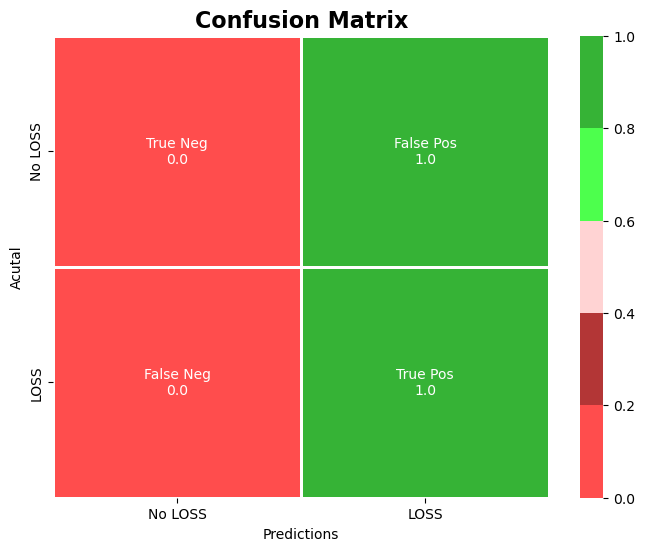

In [43]:
confusion_display(df_test.iloc[:, -1].values, log_reg_preds)

## - XGBoost Classifier

In [44]:
xgb_clf = xgb.XGBClassifier(objective="binary:logistic",
                                       sampling_method="gradient_based", 
                                       tree_method="gpu_hist", 
                                       grow_policy="lossguide", 
                                       predictor="gpu_predictor", verbosity=3, random_state=42, n_jobs=-1, **xgb_best_hyp)

print(xgb_clf, "\n\n")
xgb_pred, xgb_class_rep, xgb_clf_trained = model_results(df_train, df_test, xgb_clf)

print(clr.S+"====== XGBoost Classification Report ======"+clr.E)
print(xgb_class_rep)

XGBClassifier(alpha=3.6552109791747087, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6154000244717094, early_stopping_rounds=None,
              enable_categorical=False, eta=0.00011352037010541905,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, lambda=8.827585494454805,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=26,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=2600, n_jobs=-1, ...) 


[16:10:26] ======== Monitor (0): HostSketchContainer ========
[16:10:26] AllReduce: 0.000842s, 1 calls @ 842us

[16:10:26] MakeCuts: 0.00087s, 1 calls @ 870us

[16:10:26] DEBUG: ../src/tree/updater_gpu_hist

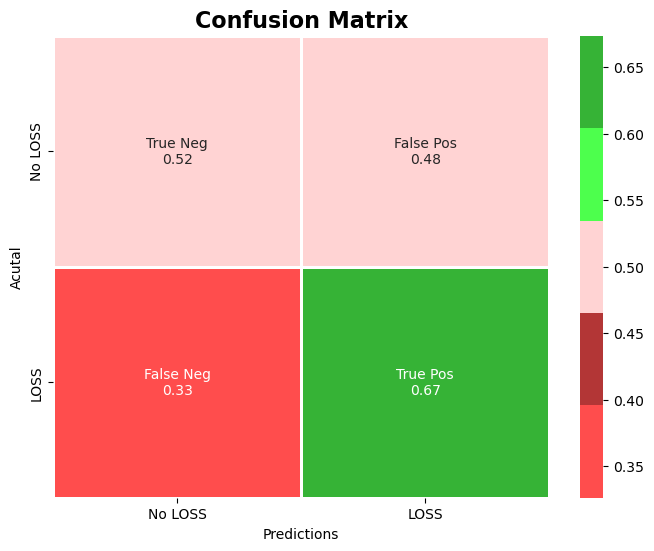

In [45]:
confusion_display(df_test.iloc[:, -1].values, xgb_pred)

In [54]:
xgb_clf_trained['model'].feature_importances_

array([0.06847694, 0.01335803, 0.67817503, 0.05193973, 0.0496623 ,
       0.01474589, 0.12364207], dtype=float32)

In [55]:
df_train.head()

,hops,charging,counter,volts,board_temp,room_temperature,room_pressure,is_packet_loss
44797,1,0,54277,4105.2,38.5,NaN,NaN,0
19366,1,0,22641,4116.2,37.1,32.780488,101690.0732,0
16525,1,0,19234,4116.2,30.4,26.242500,100655.2250,0
4868,1,0,4170,4123.9,37.0,30.940541,100684.7297,0
21140,1,0,24890,4112.9,28.8,26.133333,102548.6667,0


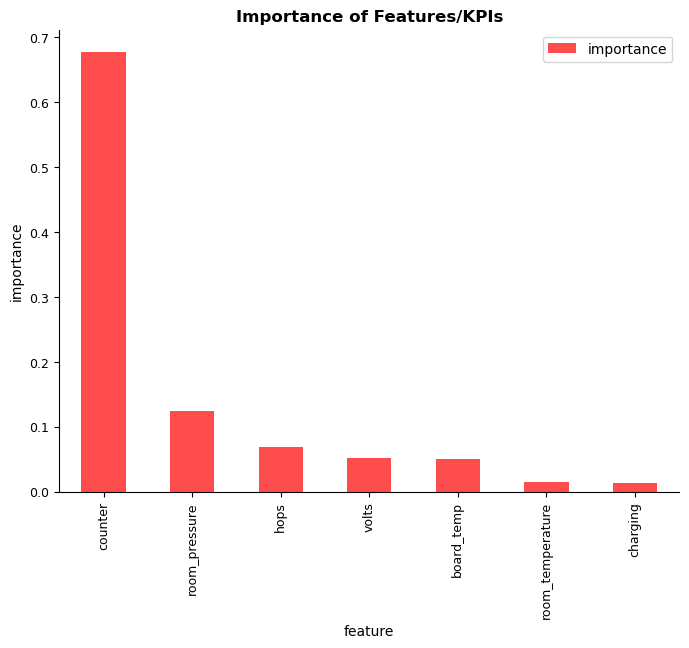

In [78]:
ax = pd.DataFrame({'features':df_train.columns[:-1], 'importance':xgb_clf_trained['model'].feature_importances_})\
.sort_values(by="importance", ascending=False)\
.set_index("features").plot(kind="bar", 
                            color=MY_COLORS[0], fontsize=9, figsize=(8, 6))

ax.set_title("Importance of Features/KPIs", fontsize=12, weight="bold")
ax.set_xlabel("feature", fontsize=10)
ax.set_ylabel("importance", fontsize=10)
ax.spines["right"].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()